In [1]:
# Script to compute TOU pricing for each time period in a dataset and return a modified dataset.
# Input: CSV file of daily consumption with time/date data as one column
# Output: CSV file of daily consumption with TOU pricing data added

# TODO: Merge this with csv_mod.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'


In [14]:
# Load LBNL Building 59 electricity consumption data. Note that this is in kW at 15-minute frequency.

df = pd.read_csv('ele.csv')
df["date"]= pd.to_datetime(df.date)
df = df.set_index("date")
df["load"]= df.sum(axis=1)


In [19]:
df = df.reindex(pd.date_range(start="01-01-2018", end="12-31-2019 23:45:00", freq="15T"))
df.iloc[0] = df.iloc[4]
df = df.interpolate()

In [20]:
df

,mels_S,lig_S,mels_N,hvac_N,hvac_S,load
2018-01-01 00:00:00,1.200000,0.2000,7.500000,37.400002,19.500000,65.800002
2018-01-01 00:15:00,1.200000,0.2000,7.500000,37.400002,19.500000,65.800002
2018-01-01 00:30:00,1.200000,0.2000,7.500000,37.400002,19.500000,65.800002
2018-01-01 00:45:00,1.200000,0.2000,7.500000,37.400002,19.500000,65.800002
2018-01-01 01:00:00,1.200000,0.2000,7.500000,37.400002,19.500000,65.800002
...,...,...,...,...,...,...
2019-12-31 22:45:00,1.966667,0.0000,8.522500,23.945000,27.531053,61.965219
2019-12-31 23:00:00,1.788889,0.0000,8.365000,23.847368,25.157895,59.159152
2019-12-31 23:15:00,1.720000,0.1000,8.779000,24.378947,25.552632,60.530579
2019-12-31 23:30:00,1.997778,0.4100,8.511429,23.842105,25.731579,60.492891


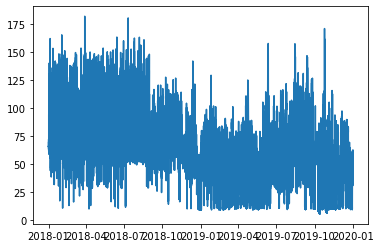

In [21]:
plt.plot(df.index, df.load)

In [22]:
# Tariff rate data for PG&E Rate B-10 (Medium General Demand Metered Service)
# TODO: Try B-19? (Medium General Demand-Metered TOU Service)

SUMMER_MONTHS = [6, 7, 8, 9]  # June 1 through Sept 30
WINTER_MONTHS = [1, 2, 3, 4, 5, 10, 11, 12]  # Oct 1 through May 31
ON_PEAK = [
    16, 
    17, 
    18, 
    19, 
    20]  # 4pm - 9pm, same for all days in all seasons

SUMMER_PARTIAL_PEAK = [
    14,
    15,
    21,
    22,
]  # 2pm - 4pm, 9pm - 11pm
SUMMER_OFF_PEAK = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    23,
]  # All other hours outside summer PEAK, SUMMER_PARTIAL_PEAK, SUMMER_OFF_PEAK

WINTER_OFF_PEAK = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    21,
    22,
    23,
]  # All other hours outside Winter PEAK
WINTER_SUPER_OFF_PEAK_MAR_APR_MAY = [
    9,
    10,
    11,
    12,
    13,
]  # 9am - 2pm

# TOU charges, all in $/kWh
SUM_ON_PEAK_TOU = 0.31411
SUM_PART_PEAK_TOU = 0.25242 
SUM_OFF_PEAK_TOU = 0.21985 

WIN_ON_PEAK_TOU = 0.23784 
WIN_OFF_PEAK_TOU = 0.20236
WIN_SUP_OFF_PEAK_TOU = 0.16602

# Peak demand charges, all in $/kW
SUM_PEAK_DEMAND_CHARGE = 17.47
WIN_PEAK_DEMAND_CHARGE = 17.47


df = df.assign(tariff="")
df = df.assign(peakdemand="")

# Summer TOU pricing:
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(ON_PEAK),
    "tariff",
] = SUM_ON_PEAK_TOU
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(SUMMER_PARTIAL_PEAK),
    "tariff",
] = SUM_PART_PEAK_TOU
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
    & df.index.hour.isin(SUMMER_OFF_PEAK),
    "tariff",
] = SUM_OFF_PEAK_TOU

# Winter TOU pricing:
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(ON_PEAK),
    "tariff",
] = WIN_ON_PEAK_TOU
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(WINTER_OFF_PEAK),
    "tariff",
] = WIN_OFF_PEAK_TOU
df.loc[
    df.index.month.isin(WINTER_MONTHS)
    & df.index.hour.isin(SUMMER_OFF_PEAK),
    "tariff",
] = WIN_SUP_OFF_PEAK_TOU

# Adjust March, April, and May TOU periods:
df.loc[
    df.index.month.isin([3, 4, 5])
    & df.index.hour.isin(WINTER_SUPER_OFF_PEAK_MAR_APR_MAY),
    "tariff",
] = WIN_SUP_OFF_PEAK_TOU


# Summer peak pricing:
df.loc[
    df.index.month.isin(SUMMER_MONTHS),
    "peakdemand",
] = SUM_PEAK_DEMAND_CHARGE

# Winter peak pricing:
df.loc[
    df.index.month.isin(WINTER_MONTHS),
    "peakdemand",
] = WIN_PEAK_DEMAND_CHARGE


In [23]:
df.loc[
    df.index.month.isin(SUMMER_MONTHS)
]

,mels_S,lig_S,mels_N,hvac_N,hvac_S,load,tariff,peakdemand
2018-06-01 00:00:00,5.900000,3.900,13.800000,21.400000,22.100000,67.100000,0.21985,17.47
2018-06-01 00:15:00,4.500000,3.600,12.900000,20.390000,18.000000,59.390000,0.21985,17.47
2018-06-01 00:30:00,3.800000,3.600,11.700000,21.000000,42.200000,82.300000,0.21985,17.47
2018-06-01 00:45:00,3.800000,3.500,13.200000,44.100000,18.890000,83.490000,0.21985,17.47
2018-06-01 01:00:00,3.400000,2.200,13.200000,43.200000,19.890000,81.890000,0.21985,17.47
...,...,...,...,...,...,...,...,...
2019-09-30 22:45:00,6.933333,3.900,29.716667,0.000000,0.000000,40.550000,0.25242,17.47
2019-09-30 23:00:00,6.733333,3.825,29.020000,2.923077,0.000000,42.501410,0.21985,17.47
2019-09-30 23:15:00,6.120000,3.750,22.466667,0.000000,0.000000,32.336667,0.21985,17.47
2019-09-30 23:30:00,6.300000,3.800,18.275000,3.268421,0.000000,31.643421,0.21985,17.47


In [24]:
# Save to CSV
df.to_csv("load_tariff_LBNL_bldg59.csv")

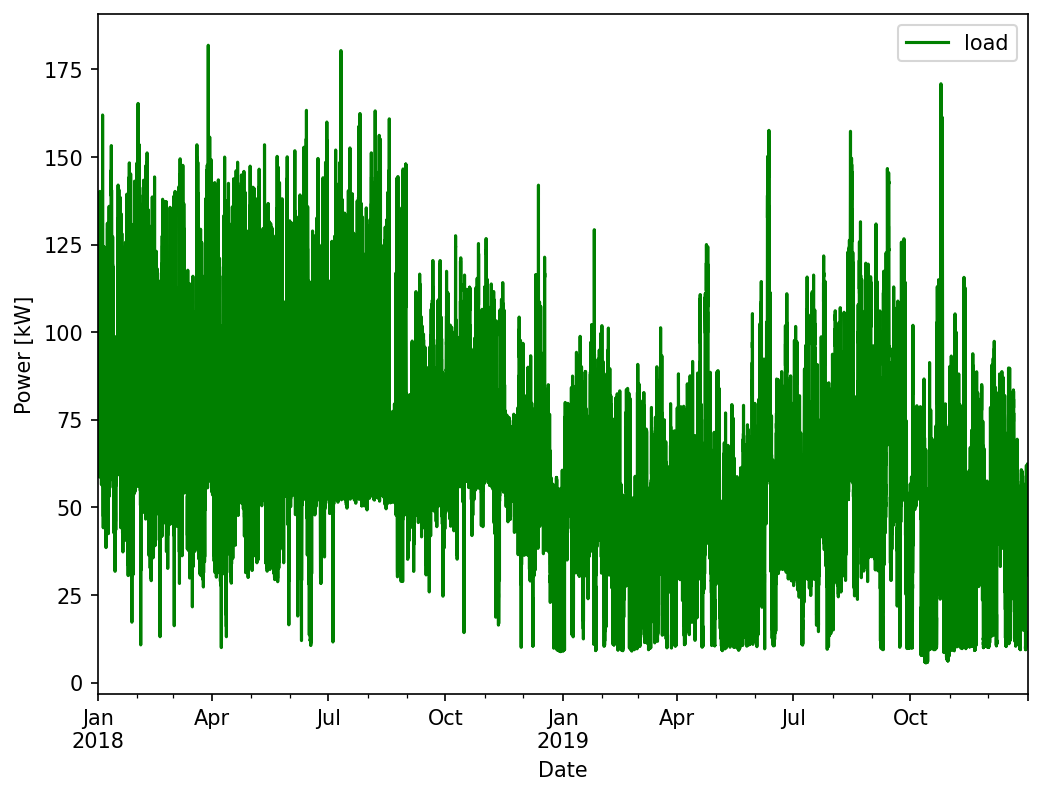

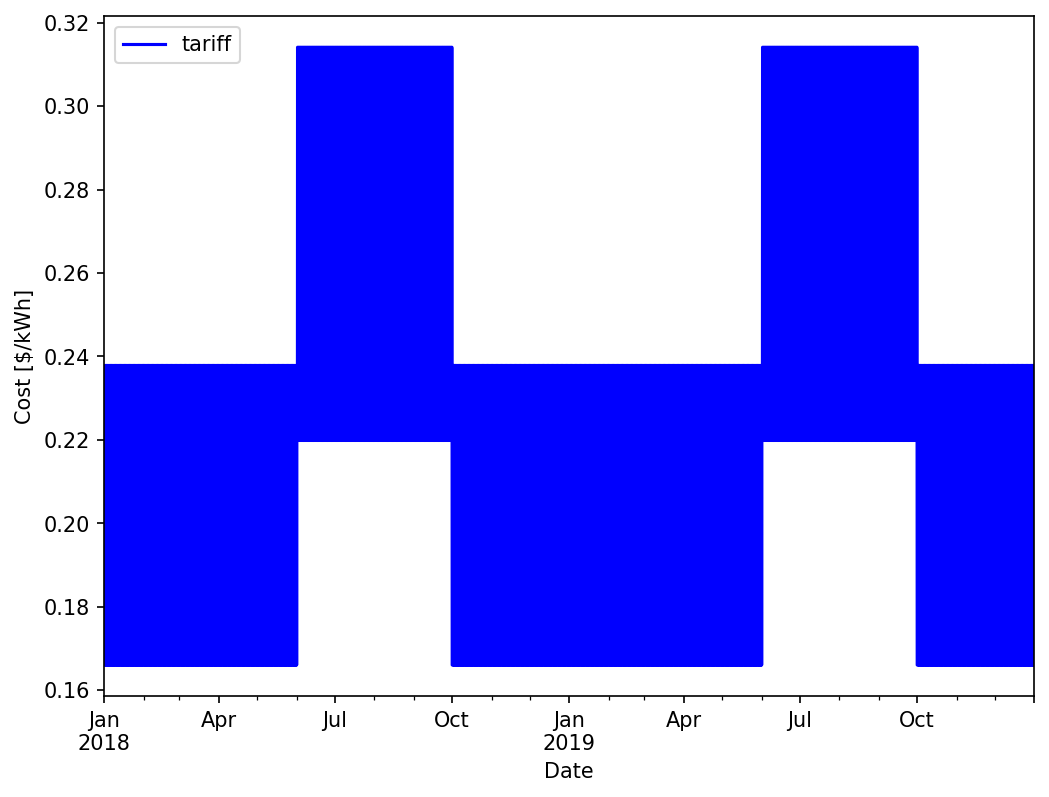

In [25]:
# Plot!
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = plt.gca()
# df.plot(kind='line', x='dt', y='grid', ax=ax, xlabel='Date', ylabel='Power, kW')
# df.plot(kind='line', x='dt', y='solar', color='red', ax=ax, xlabel='Date', ylabel='Power, kW')
df.plot(
    kind="line",
    y="load",
    color="green",
    ax=ax,
    xlabel="Date",
    ylabel="Power [kW]",
)
fig.savefig("load_data_LBNL_bldg59.png")

# Plot tariff rate!
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = plt.gca()
# df.plot(kind='line', x='dt', y='grid', ax=ax, xlabel='Date', ylabel='Power, kW')
# df.plot(kind='line', x='dt', y='solar', color='red', ax=ax, xlabel='Date', ylabel='Power, kW')
df.plot(
    kind="line",
    y="tariff",
    color="blue",
    ax=ax,
    xlabel="Date",
    ylabel="Cost [$/kWh]",
)
fig.savefig("tariff_data_LBNL_bldg59.png")

